In [1]:
!git clone https://github.com/kieferk/pymssa.git

Cloning into 'pymssa'...
remote: Enumerating objects: 85, done.
remote: Total 85 (delta 0), reused 0 (delta 0), pack-reused 85
Unpacking objects: 100% (85/85), done.


In [2]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.metrics import r2_score
from pymssa.pymssa.mssa import MSSA

/content/pymssa/pymssa/mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [37]:
df = pd.read_csv('/content/drive/MyDrive/VDT2022/mini-project/stroke_recovery_dataset/protocol/sb01.csv')
cols = ['counts', 'speed']
data_df = df.loc[df.index, cols]
data_df = data_df.interpolate()
df.head(5)

,Unnamed: 0,Date,counts,speed
0,0,2020-01-01,394.0,1.1506
1,1,2020-01-02,397.0,1.1504
2,2,2020-01-03,382.0,1.1563
3,3,2020-01-04,395.0,1.1561
4,4,2020-01-05,394.0,1.1540


In [38]:
tp = 92

data_train = data_df.iloc[:-tp]
data_test = data_df.iloc[-tp:]

In [5]:
# tr_means = np.nanmean(data_train, axis=0)
# data_train = data_train - tr_means
# data_test = data_test - tr_means

In [39]:
mssa = MSSA(n_components=None,
            window_size=None,
            verbose=True)

In [40]:
ts = np.arange(10)
ts

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [41]:
window = 5
trajmat = scipy.linalg.hankel(ts, np.zeros(window)).T
trajmat = trajmat[:, :(10 - window + 1)]
trajmat

array([[0., 1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5., 6.],
       [2., 3., 4., 5., 6., 7.],
       [3., 4., 5., 6., 7., 8.],
       [4., 5., 6., 7., 8., 9.]])

In [42]:
trajmat[:, :5]

array([[0., 1., 2., 3., 4.],
       [1., 2., 3., 4., 5.],
       [2., 3., 4., 5., 6.],
       [3., 4., 5., 6., 7.],
       [4., 5., 6., 7., 8.]])

In [43]:
mssa.fit(data_train)

Constructing trajectory matrix
Trajectory matrix shape: (274, 138)
Decomposing trajectory covariance matrix with SVD
Constructing components


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


Calculating optimal reconstruction orders


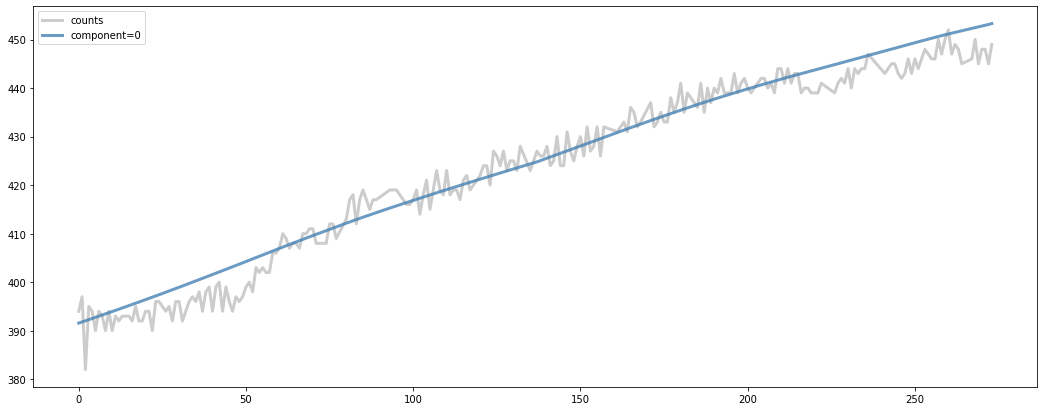

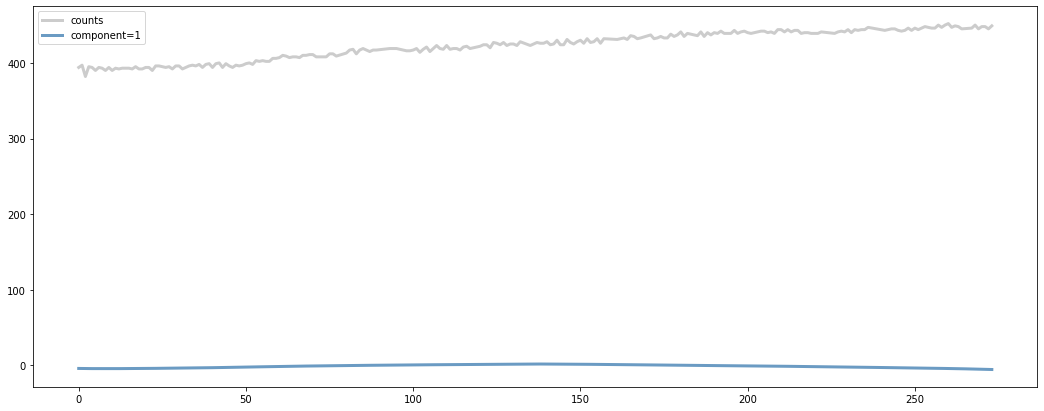

In [44]:
idx = 0

for comp in range(2):  
    fig, ax = plt.subplots(figsize=(18, 7))
    ax.plot(data_train.index, data_train.iloc[:, idx].values, lw=3, alpha=0.2, c='k', label=data_train.columns[idx])
    ax.plot(data_train.index, mssa.components_[idx, :, comp], lw=3, c='steelblue', alpha=0.8, label='component={}'.format(comp))
    ax.legend()
    plt.show()

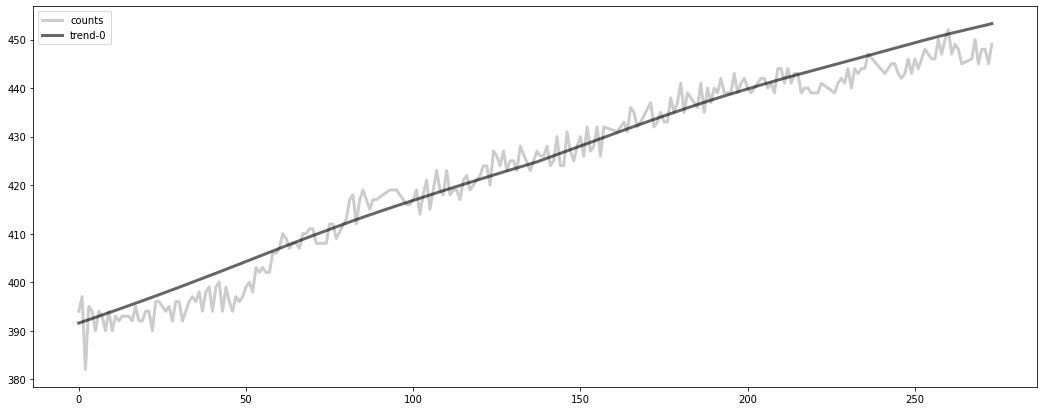

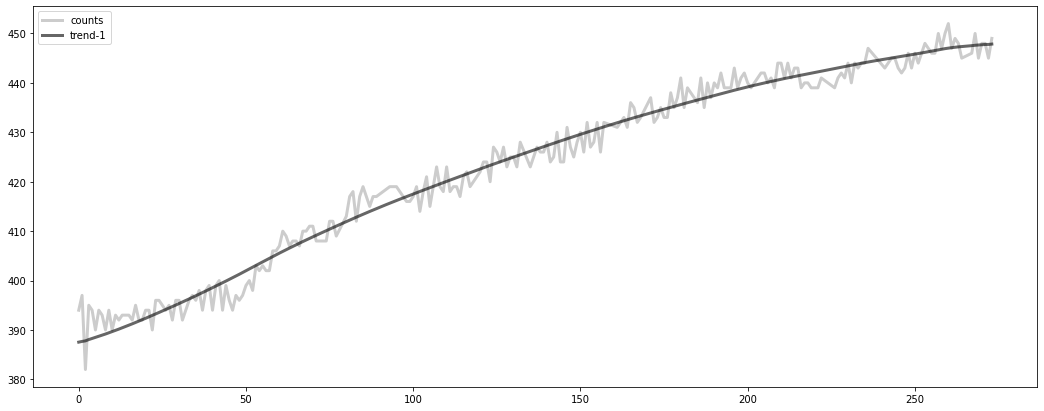

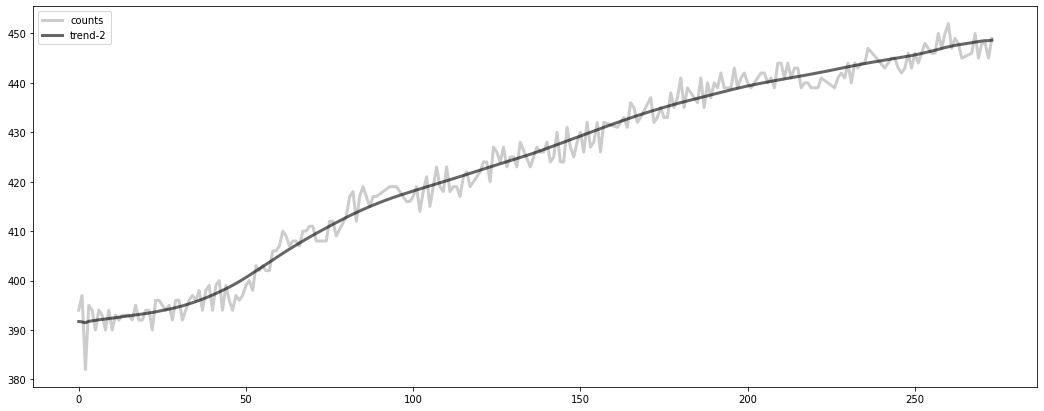

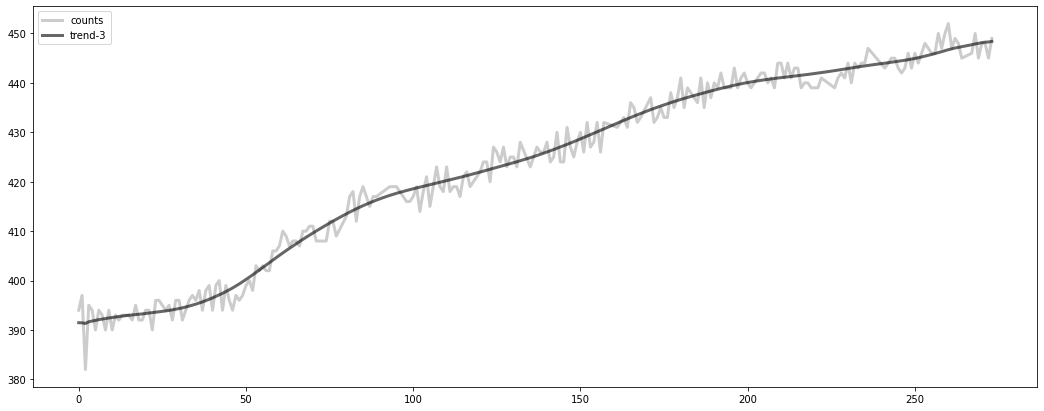

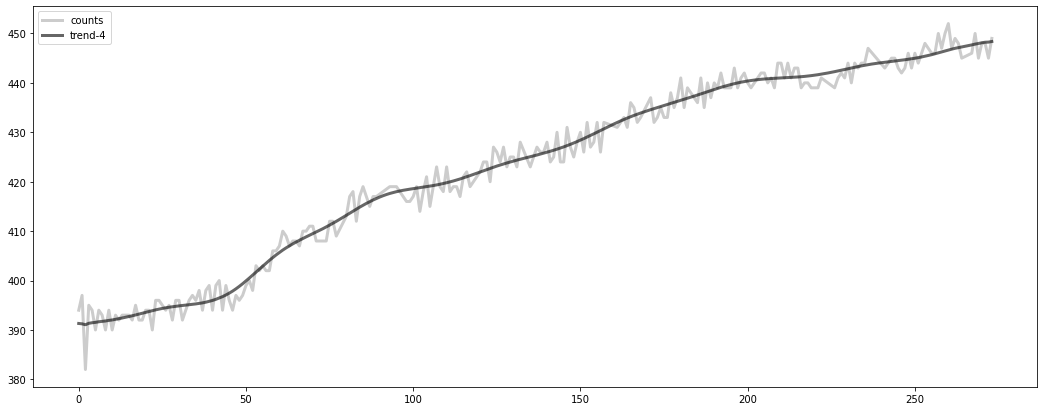

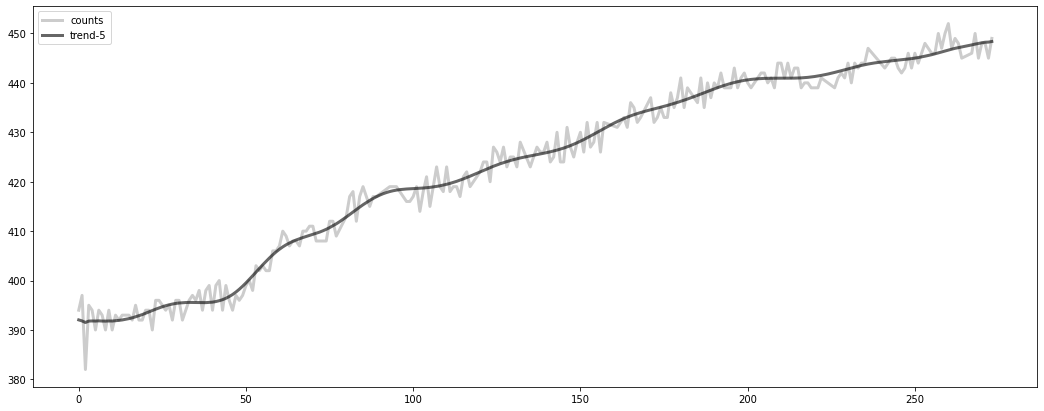

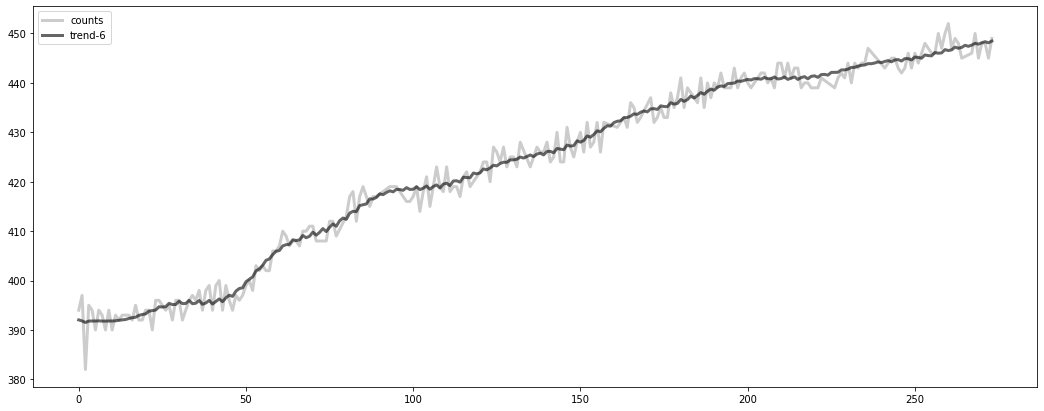

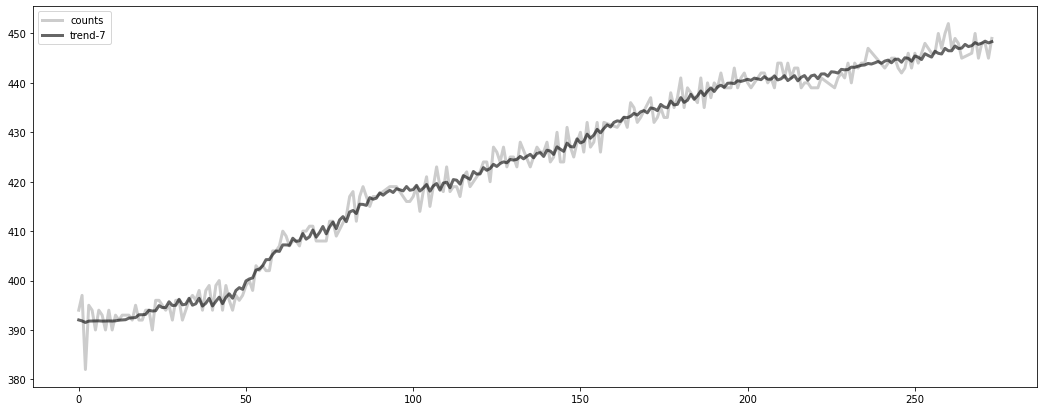

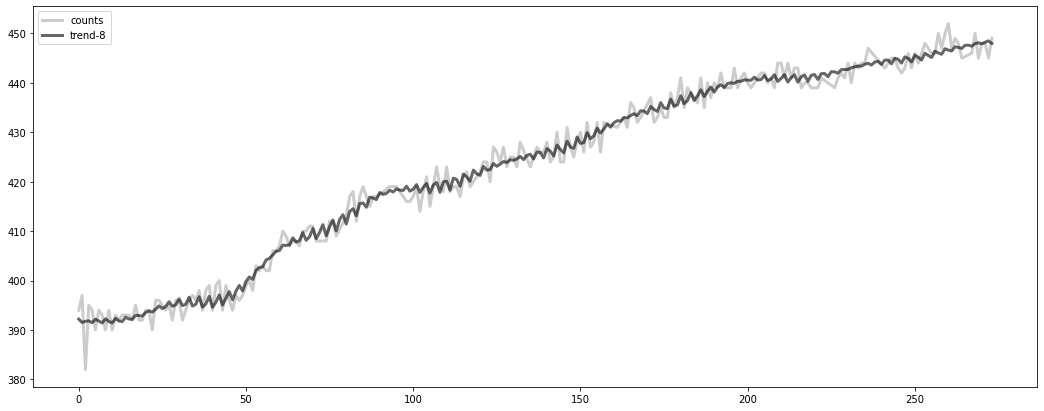

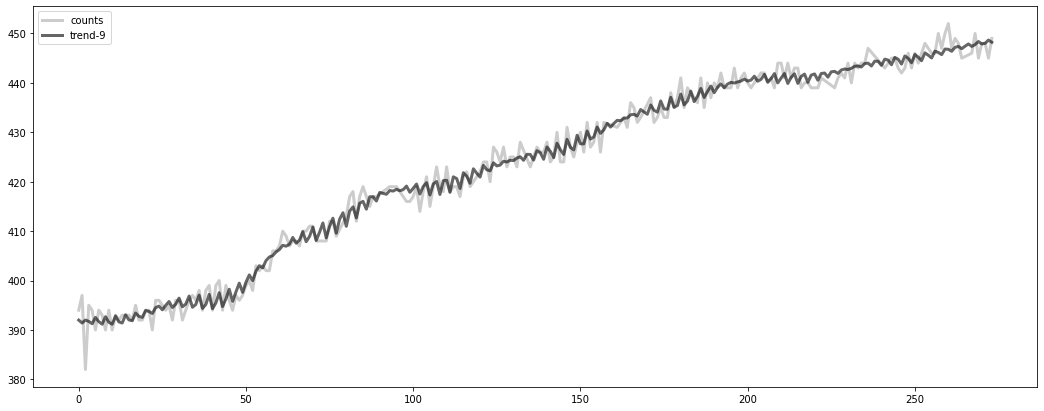

In [45]:
idx = 0

cumulative_recon = np.zeros_like(data_train.iloc[:, idx].values)
trend_test = []
for comp in range(10):  
    fig, ax = plt.subplots(figsize=(18, 7))
    current_component = mssa.components_[idx, :, comp]
    cumulative_recon = cumulative_recon + current_component

    ax.plot(data_train.index, data_train.iloc[:, idx].values, lw=3, alpha=0.2, c='black', label=data_train.columns[idx])
    ax.plot(data_train.index, cumulative_recon, lw=3, c='black', alpha=0.6, label=f'trend-{comp}'.format(comp))
    # ax.plot(data_train.index, current_component, lw=3, c='black', alpha=0.8, label=f'noise-{comp}'.format(comp))
    trend_test.append(cumulative_recon)
    
    ax.legend()
    plt.show()

In [46]:
trend_test[5].shape

(274,)

In [ ]:
trend_test[5].tolist()

In [48]:
df1 = pd.DataFrame({'trend_speed': pd.Series(trend_test[5].tolist())})
df1.to_csv('trend_speed.csv')

In [28]:
mssa.component_ranks_[0:5]

array([[ 0,  0],
       [ 1,  1],
       [10, 15],
       [ 4, 10],
       [12, 11]])

In [29]:
mssa.component_ranks_explained_variance_[0:5]

array([[0.74007055, 0.70481406],
       [0.610076  , 0.63300589],
       [0.0034585 , 0.00625163],
       [0.00267394, 0.01013339],
       [0.00075383, 0.00423554]])

In [30]:
total_comps = mssa.components_[0, :, :]
print(total_comps.shape)

(274, 138)


In [31]:
total_wcorr = mssa.w_correlation(total_comps)
total_wcorr_abs = np.abs(total_wcorr)

Text(0.5, 1.0, 'counts component w-correlations')

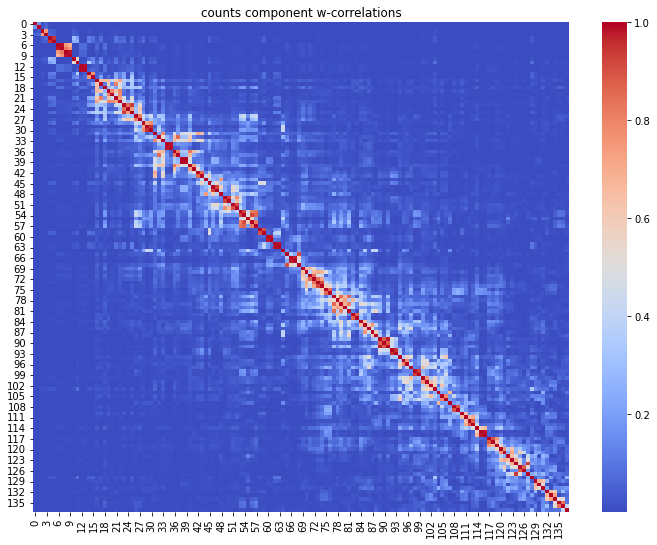

In [32]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(total_wcorr_abs), cmap='coolwarm', ax=ax)
ax.set_title('{} component w-correlations'.format(data_train.columns[0]))

In [33]:
ts0_groups = [
    [0,1],
    [2,3],
    [4],
    [5,6],
    [7],
    [8,9],
    [10,11],
    [12],
    [13,14],
    [15,16],
    [17,18,19,20]
]

In [45]:
mssa.set_ts_component_groups(0, ts0_groups)
mssa.component_groups_[0]

Exception: ignored

In [35]:
ts0_grouped = mssa.grouped_components_[0]
ts0_grouped.shape

(274, 11)

Text(0.5, 1.0, 'counts grouped component w-correlations')

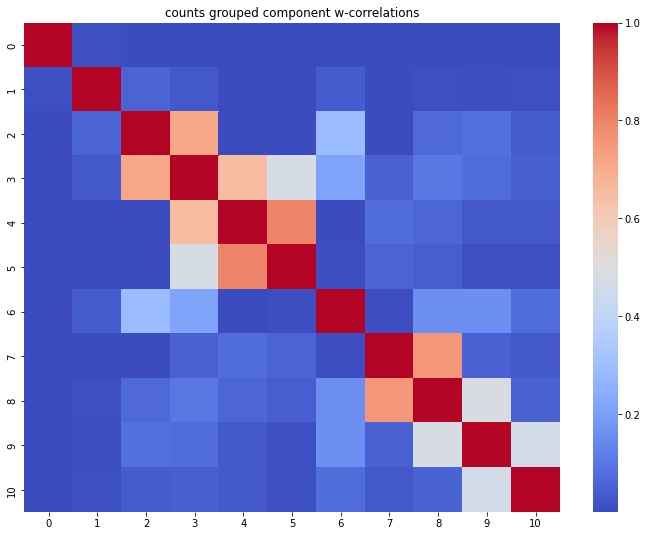

In [36]:
ts0_grouped_wcor = mssa.w_correlation(ts0_grouped)
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(np.abs(ts0_grouped_wcor), cmap='coolwarm', ax=ax)
ax.set_title('{} grouped component w-correlations'.format(data_train.columns[0]))


In [37]:
mssa = MSSA(n_components='svht',
            window_size=None,
            verbose=True)
mssa.fit(data_train)
print(mssa.components_.shape)

Constructing trajectory matrix
Trajectory matrix shape: (274, 138)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 10 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders
(2, 274, 10)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


In [ ]:
mssa = MSSA(n_components='variance_threshold',
            variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
mssa.fit(data_train)
print(mssa.components_.shape)

Constructing trajectory matrix
Trajectory matrix shape: (290, 146)
Decomposing trajectory covariance matrix with SVD


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


Reduced rank to 1 according to variance explained threshold
Constructing components
Calculating optimal reconstruction orders
(2, 290, 1)


In [ ]:
mssa = MSSA(n_components='parallel_analysis',
            pa_percentile_threshold=95,
            window_size=None,
            verbose=True)
mssa.fit(data_train)
print(mssa.components_.shape)

Constructing trajectory matrix
Trajectory matrix shape: (290, 146)
Decomposing trajectory covariance matrix with SVD
Performing parallel analysis to determine optimal rank


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:376: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  FutureWarning,


  0%|          | 0/100 [00:00<?, ?it/s]

Rank selected via parallel analysis: 2
Constructing components
Calculating optimal reconstruction orders
(2, 290, 2)


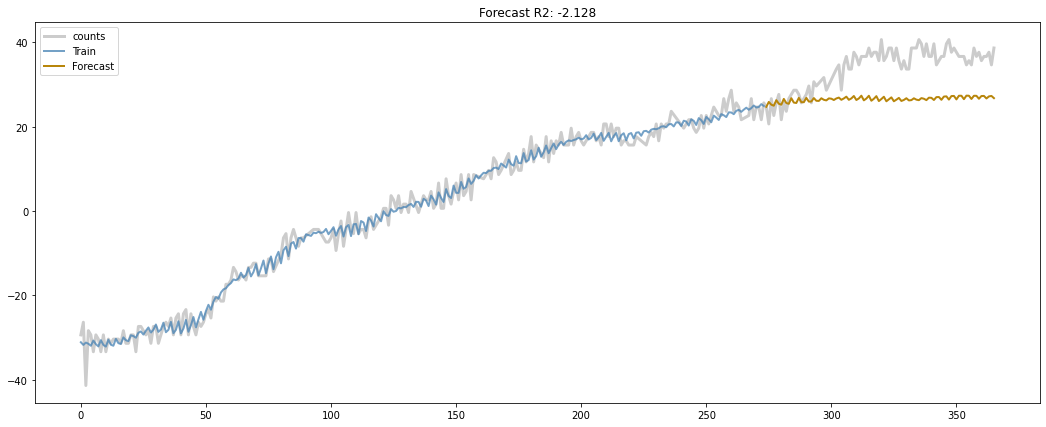

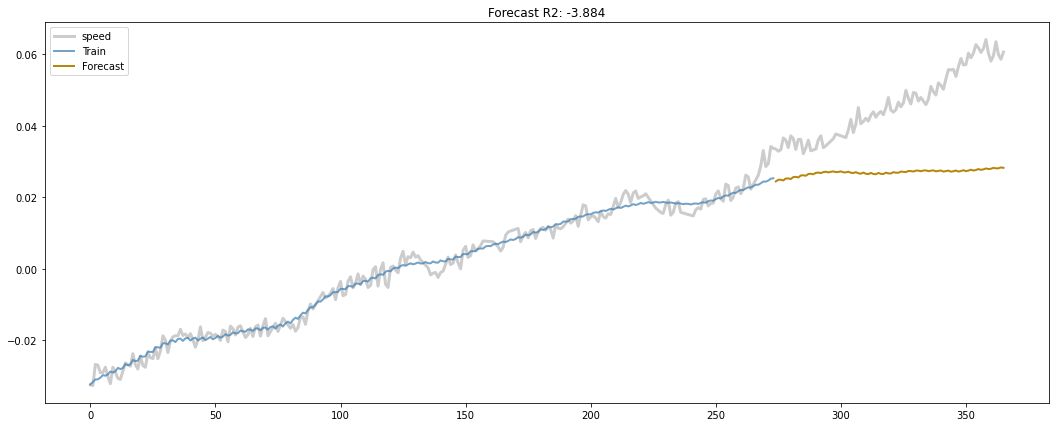

In [43]:
data_c = data_df - tr_means

for ts_index in range(data_c.shape[1]):
    tr = np.zeros(data_c.shape[0])
    tr[:] = np.nan

    te = np.copy(tr)

    tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
    fc = mssa.forecast(tp, timeseries_indices=ts_index)
    
    ytrue = data_test.iloc[:, ts_index].values
    yhat = fc.ravel()[~pd.isnull(ytrue)]
    ytrue = ytrue[~pd.isnull(ytrue)]
    
    r2 = r2_score(ytrue, yhat)
    te[-tp:] = fc

    fig, ax = plt.subplots(figsize=(18, 7))
    ax.plot(data_c.index, data_c.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=data_c.columns[ts_index])
    ax.plot(data_c.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
    ax.plot(data_c.index, te, lw=2, c='darkgoldenrod', label='Forecast')
    ax.set_title('Forecast R2: {:.3f}'.format(r2))
    ax.legend()
    
    plt.show()